In [8]:
!pip install -q qiskit qiskit-aer sympy pylatexenc

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator

from fractions import Fraction
import numpy as np
import random
import sympy
import math

In [10]:
class CtrlMultCircuit(QuantumCircuit):
    """
    Унітарний оператор U_k для алгоритму Шора:
    реалізує відображення |y> → |a^(2^k) * y mod N>
    """
    def __init__(self, a: int, binary_power: int, N: int):
        # Робочий регістр повинен представляти числа 0..N-1
        n = max(1, N.bit_length())  # кількість кубітів робочого регістру
        super().__init__(n, name=f"U_{a}^(2^{binary_power}) mod {N}")
        self.a = a
        self.N = N
        self.n = n
        # Обчислюємо множник a^(2^k) mod N (використовується у QPE)
        self.power = pow(a, 1 << binary_power, N)  # a^(2^k) mod N

        self._create_circuit()

    def _create_circuit(self):
        # Створюємо унітарну матрицю U для відображення станів |y>
        dim = 1 << self.n
        U = np.zeros((dim, dim), dtype=complex)

        coprime = (math.gcd(self.a, self.N) == 1)
        for y in range(dim):
            if coprime and y < self.N:
                # Основне модульне відображення a^(2^k) * y mod N
                y2 = (self.power * y) % self.N
            else:
                # Для станів поза діапазоном [0..N-1] — тотожне відображення
                y2 = y
            U[y2, y] = 1.0 # U|y> = |y2>

        # Додаємо U як квантовий gate, що діє на весь робочий регістр
        self.append(UnitaryGate(U, label=self.name), range(self.n))

In [11]:
class QPECircuit(QuantumCircuit):
    """
    QPE-схема для знаходження фази оператора U:
        U |y> = |a * y mod N>.
    Використовується для оцінки порядку r в алгоритмі Шора.

    Регістри:
      - count: n_count кубітів для фазової оцінки
      - work:  n_work кубітів, що зберігають стани mod N (початковий стан |1>)
    """
    def __init__(self, a: int, N: int, n_count: int = None):
        n_work = max(1, N.bit_length()) # розмір робочого регістру
        if n_count is None:
            n_count = 2 * n_work  # стандарт для точної QPE

        q_count = QuantumRegister(n_count, "count")
        q_work  = QuantumRegister(n_work,  "work")
        c_count = ClassicalRegister(n_count, "c")
        super().__init__(q_count, q_work, c_count, name="QPE_Ua")

        self.a = a
        self.N = N
        self.n_count = n_count
        self.n_work = n_work

        self._create_circuit()

    def _apply_modexp(self):
        # Послідовно застосовуємо U^(2^k), контрольоване кубітом count[k]
        count, work = self.qregs[0], self.qregs[1]
        for k in range(self.n_count):
            u = CtrlMultCircuit(self.a, k, self.N).to_gate()
            self.append(u.control(1), [count[k]] + list(work))

    def _create_circuit(self):
        count = self.qregs[0]
        work  = self.qregs[1]

        # Крок 1: створюємо рівномірну суперпозицію в лічильному регістрі
        self.h(count)

        # Крок 1b: ініціалізуємо робочий регістр у |1>
        self.x(work[0])

        self.barrier()

        # Крок 2: контрольована модульна експонента U^(2^k)
        self._apply_modexp()
        self.barrier()

        # Крок 3: застосовуємо інверсний QFT для витягнення фази
        self.append(QFT(self.n_count, inverse=True, do_swaps=True), count)

        # Крок 4: вимірюємо фазу
        self.measure(count, self.cregs[0])

    def run(self, simulator: AerSimulator):
        transpiled = transpile(self, simulator)
        return simulator.run(transpiled, memory=True).result()

In [12]:
class ShorAlgorithm:
    """
    Класична “обгортка” навколо квантової частини алгоритму Шора.
    Виконує:
      - попередні перевірки N,
      - квантове знаходження порядку r (через QPE),
      - класичну постобробку для обчислення нетривіальних дільників N.
    """
    def __init__(self, N: int, max_attempts: int = -1, random_coprime_only: bool = False, simulator=None):
        self.N = N
        self.simulator = simulator or AerSimulator()
        self.max_attempts = max_attempts # максимум спроб різних a (-1 = без обмежень)
        self.random_coprime_only = random_coprime_only
        self.qpe_last = None # остання побудована QPE-схема (для візуалізації)
        self.last_measure_bin = None # останній результат вимірювання (у двійковому вигляді)
        self.last_phase_frac = None # остання фаза у вигляді (чисельник, знаменник)

    # Перевірки та «простий» факторинг перед квантовою частиною
    def _is_N_invalid(self):
        # N має бути більше 3, інакше задача факторизації тривіальна
        if self.N <= 3:
            print('[ERR] N must be > 3')
            return 1, self.N

        # парне N одразу дає фактор 2
        if self.N % 2 == 0:
            print(f'=> {self.N} is even: {self.N} = 2 * {self.N // 2}')
            return 2, self.N // 2

        # просте N теж дає тривіальну факторизацію
        if sympy.isprime(self.N):
            print(f'=> {self.N} is prime: {self.N} = 1 * {self.N}')
            return 1, self.N

        # перевірка, чи не є N степенем простого: N = p^k
        max_exponent = int(math.log2(self.N))
        for k in range(max_exponent, 1, -1):
            p = round(self.N ** (1 / k))
            if p ** k == self.N:
                print(f'=> {self.N} is a perfect power: {self.N} = {p}^{k}')
                return p, k
        return False

    # Квантове знаходження порядку r через QPE та продовжені дроби
    def _quantum_period_finding(self, a: int) -> int:
        n_work = max(1, self.N.bit_length())
        n_count = 2 * n_work
        while True:
            # будуємо та запускаємо QPE-схему для оператора U_a
            qpe = QPECircuit(a, self.N, n_count=n_count)  # створює схему
            self.qpe_last = qpe
            result = qpe.run(self.simulator)

            # зчитуємо результат вимірювання фазового (лічильного) регістру
            state_bin = result.get_memory()[0]
            state_dec = int(state_bin, 2)
            bits_count = 1 << n_count  # знаменник = 2^n_count

            self.last_measure_bin = state_bin
            self.last_phase_frac = (state_dec, bits_count)

            # відновлюємо фазу як раціональне число й дістаємо кандидат на порядок r
            frac = Fraction(state_dec, bits_count).limit_denominator(self.N)
            r = frac.denominator  # знаходжу період через продовжені дроби

            print(f'>>> Measured phase: {state_dec}/{bits_count}  ->  candidate r = {r}')

            # відкидаємо очевидно некоректні кандидати
            if r in (0, 1) or r > self.N:
                print(f'[WARN] Spurious r={r}; repeating QPE...')
                continue

            # перевіряємо, що r дійсно є порядком: a^r ≡ 1 (mod N)
            if pow(a, r, self.N) == 1:
                return r
            print('[WARN] Not a true order; repeating QPE...')

    # gcd(a^{r/2} ± 1, N)
    def _classical_postprocess(self, a: int, r: int):
        print(f'>>> Found r = {r} -> compute gcd(a^(r/2) ± 1, N)')
        if r % 2 != 0: # у Шора потрібен парний порядок
            print(f'[ERR] r = {r} is odd -> pick another a')
            return None

        half = pow(a, r // 2, self.N)
        # якщо a^(r/2) ≡ -1 (mod N), фактори не покращуються
        if half == self.N - 1:
            print(f'[ERR] a^(r/2) ≡ -1 (mod {self.N}) -> pick another a')
            return None

        # нетривіальні дільники через gcd(a^(r/2) ± 1, N)
        p = math.gcd(half - 1, self.N)
        q = math.gcd(half + 1, self.N)
        if 1 < p < self.N and 1 < q < self.N:
            print(f'[DONE] Factors found: {self.N} = {p} * {q}')
            return p, q

        print(f'[FAIL] Trivial factors: [1, {self.N}]')
        return None


    def execute(self):
        # 1) класичні попередні перевірки N
        base_check = self._is_N_invalid()
        if base_check:
            return base_check

        # 2) формуємо список кандидатів a
        candidates = [a for a in range(2, self.N) if (not self.random_coprime_only) or math.gcd(a, self.N) == 1]
        random.shuffle(candidates)
        print(f'[INFO] {len(candidates)} candidate a values: {candidates}')

        limit = len(candidates) if self.max_attempts <= -1 else min(self.max_attempts, len(candidates))
        tries = 0

        # 3) перебираємо різні значення a
        for a in candidates:
            if tries >= limit:
                break
            tries += 1

            # миттєвий класичний факторинг, якщо gcd(a, N) ≠ 1
            g = math.gcd(a, self.N)
            if g != 1:
                print(f'=> gcd({a},{self.N}) = {g} -> factors: {g} * {self.N // g}')
                return g, self.N // g

            print(f'\n===== Attempt {tries}/{limit} :: a = {a} =====')

            # 4) квантове знаходження порядку r
            r = self._quantum_period_finding(a)

            # 5) класична постобробка для обчислення факторів
            factors = self._classical_postprocess(a, r)
            if factors:
                return factors

        print('[FAIL] No non-trivial factors found.')
        return None


[INFO] 7 candidate a values: [4, 14, 13, 8, 11, 2, 7]

===== Attempt 1/7 :: a = 4 =====


/tmp/ipython-input-1492934422.py:52: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  self.append(QFT(self.n_count, inverse=True, do_swaps=True), count)


>>> Measured phase: 128/256  ->  candidate r = 2
>>> Found r = 2 -> compute gcd(a^(r/2) ± 1, N)
[DONE] Factors found: 15 = 3 * 5

Result: (3, 5)


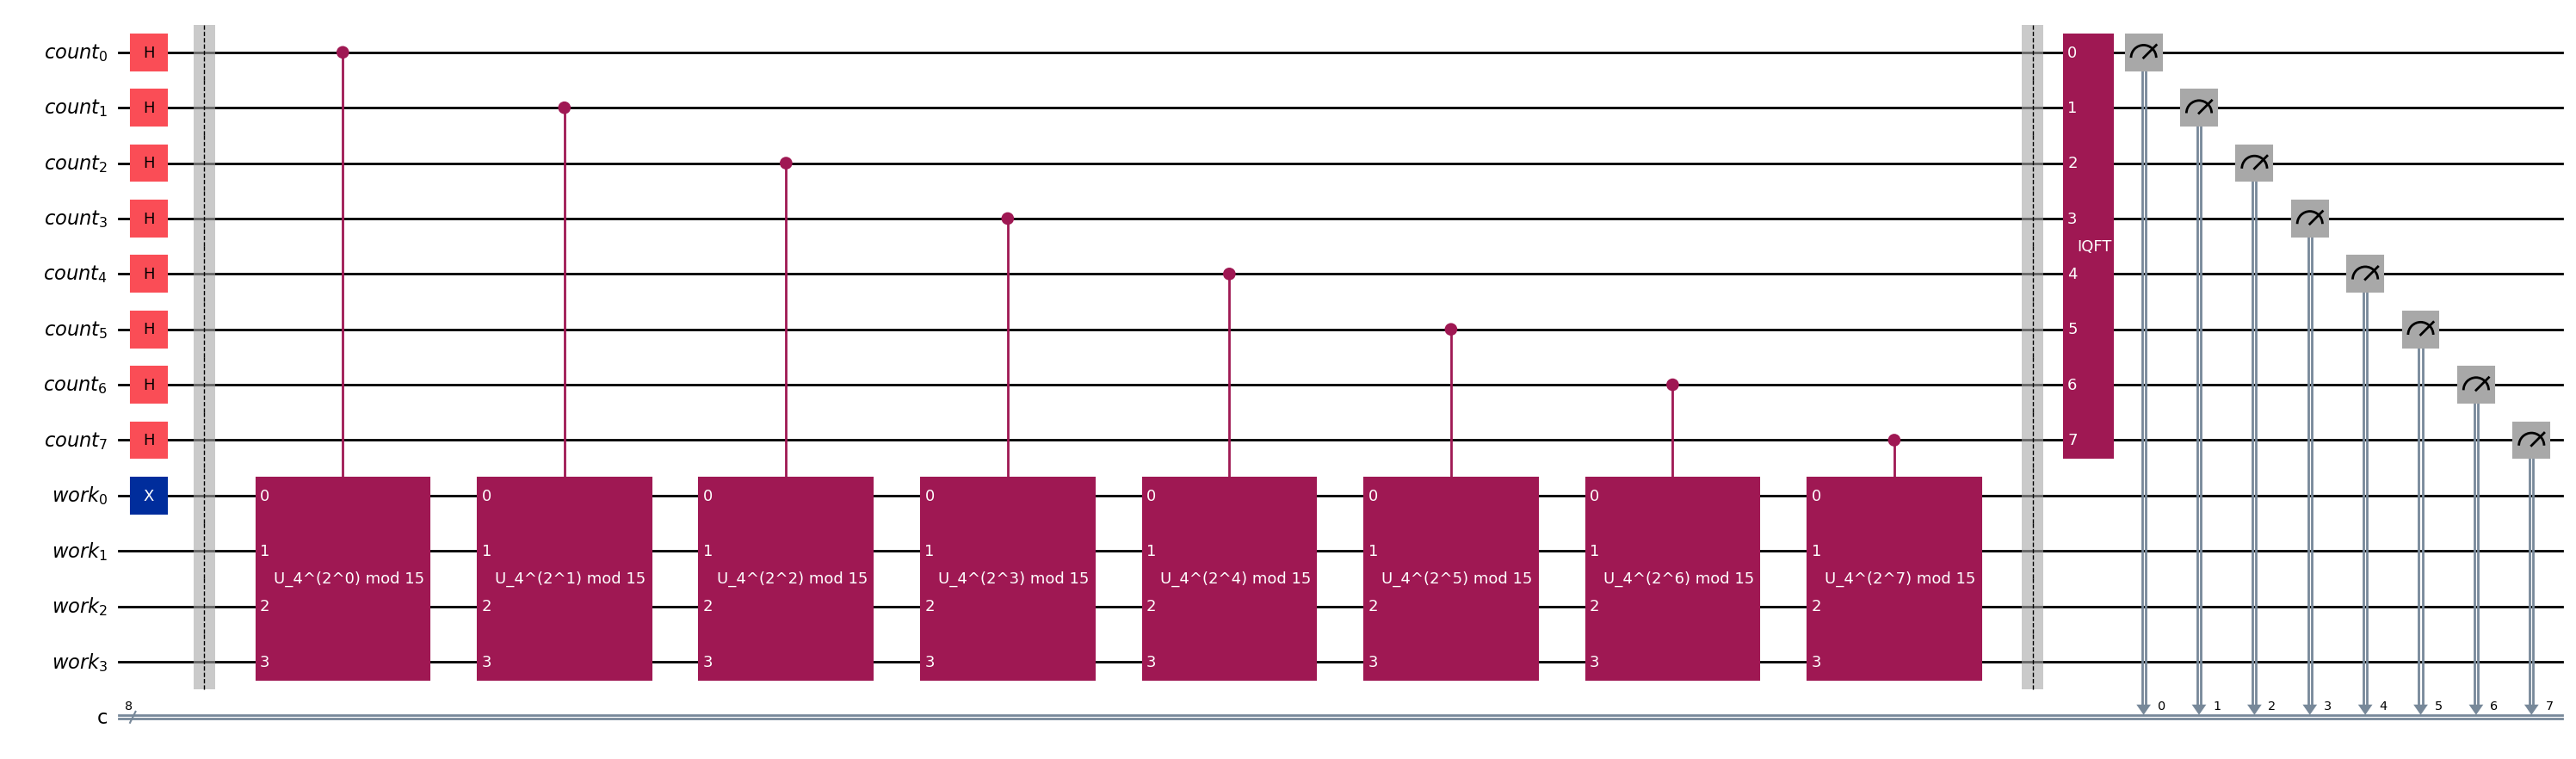


Last measured bits (little-endian): 10000000
Last measured fraction: 128/256


In [13]:
if __name__ == "__main__":
    # Параметри задачі факторизації
    number_to_factor = 15
    max_attempts = -1           # -1 = перебрати всі можливі значення a
    random_coprime_only = True  # брати лише значення a, взаємно прості з N

    # Створюємо та запускаємо алгоритм Шора
    shor = ShorAlgorithm(number_to_factor, max_attempts, random_coprime_only, AerSimulator())
    factors = shor.execute()
    print("\nResult:", factors)

    # Візуалізація останньої побудованої QPE-схеми
    try:
        display(shor.qpe_last.draw(output='mpl', fold=-1))
        print(f"\nLast measured bits (little-endian): {shor.last_measure_bin}")
        sd, bc = shor.last_phase_frac
        print(f"Last measured fraction: {sd}/{bc}")
    except Exception as e:
        print("Drawing not available:", e)